# Application: Porous catalytic combustion

This example demonstrates two 'advanced' Cantera capabilities:

- Incorporatin of heterogeneous surface chemical reactions
- Developing in-house code which relies upon Cantera to evaluate terms and properies.

The application is a plug flow through an isothermal, porous catalytic combustor:

<img src="images/PackedBedreactor.jpg"  width="550">
(Figure courtesy of Robert J. Kee, Colorado School of Mines)

While the chemistry, as pictured, can be quite complex, we will stick, in this example, to rather well understood combustion of CH$_4$ with O$_2$ on a platinum catalyst surface, as developed by O. Deutschmann:  

```Deutschman et al., 26th Symp. (Intl.) on Combustion, 1996, pp. 1747-1754.```

## Computational domain:

<img src="images/porous-cat-comb.png"  width="700">

The computational domain assumes radial and rotational symmetry (i.e. "plug flow").  Discretizing the porous catalyst bed into a series of finite volumes, each finite volume must account for the following four phenomena:

- Mass flow of species into the volume
- Mass flow of species out of the volume
- Homogeneous gas-phase reactions
- Heterogeneous surface reactions

## Model setup

Let's begin by importing some necessary modules:

In [279]:
import cantera as ct
import numpy as np
from math import pi
from scipy.integrate import solve_ivp

import time

%matplotlib notebook
import matplotlib.pyplot as plt

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['figure.autolayout'] = True

### Define the model geometry and conditions:

In [413]:
class params:
    """ Inputs  """
    L_catcomb = 0.05 # length, in m
    #L_catcomb = 0.25
    r = 0.01         # reactor radius, in m
    nz = 8           # number of finite volumes in the z-direction
    mdot = 0.0002    # kg/s
    T_reactor = 900  # K
    P_reactor = 1.0  # atm
    eps_g = .47      # Gas-phase volume fraction (aka porosity)
    tau_g = 1.6      # Gas-phase tortuosity
    d_part = 8.5e-6  # Mean particle diameter of the catalyst
    t_sim = 0.1      # time of simulation, in seconds
    a_surf = 1020    # specific catalyst surface area (m2 area per m3 of reactor)
    
    # composition of the inlet premixed gas for the methane/air case
    X_in = 'CH4:0.095, O2:0.21, N2:0.78, AR:0.01'
    
    
    """ Derived parameters """
    dzInv = nz/L_catcomb
    dz = 1/dzInv
    
    # Permeability, via the Kozeny-Carman relationship:
    K_g = 4*d_part**2*eps_g**3/(72*tau_g**2*(1-eps_g)**2)
    
    # mass flux at the inlet:
    M_in = mdot/pi/r**2

### Initialize Cantera objects and solution vector:

We will build cantera objects for the gas phase and the Pt catalyst surface.  The gas phase object will use the "Dusty Gas Transport" manager, which is appropriate for flow through porous media where molecular diffusion, pressure-driven Darcy flow, and Knudsen diffusion all occur at relevant scales:

The solution vector will store $\rho_k\,\left[\frac{\rm kg - k}{\rm m^3}\right]$ for each gas-phase species.  This inherently also gives us the total gas-phase density:

$$\rho_{\rm gas} = \sum \rho_k$$

The solution vector will also store $\theta_{k,\,s}$, the surface coverage of each surface species $k$.

In [414]:
gas = ct.Solution('input-files/porous-cat-comb/ptcombust.cti','reduced_gas')

gas.TPX = params.T_reactor, params.P_reactor*ct.one_atm, params.X_in

params.Y_in = gas.Y

surf = ct.Interface('input-files/porous-cat-comb/ptcombust.cti','Pt_surf',[gas])
surf.TP = params.T_reactor, params.P_reactor*ct.one_atm
surf()


  Pt_surf:

       temperature             900  K
          pressure          101325  Pa
           density     5.29309e-06  kg/m^3
  mean mol. weight         195.584  amu

                          1 kg            1 kmol
                       -----------      ------------
          enthalpy          -74956       -1.466e+07     J
   internal energy          -74956       -1.466e+07     J
           entropy           59.52        1.164e+04     J/K
    Gibbs function     -1.2852e+05       -2.514e+07     J
 heat capacity c_p          47.075             9207     J/K
 heat capacity c_v          47.075             9207     J/K

                           X                 Y          Chem. Pot. / RT
                     -------------     ------------     ------------
             PT(S)            0.5         0.498712        -0.693147
              H(S)            0.5         0.501288         -6.02537
     [   +9 minor]              0                0



### Let's begin by  integrating the coverage equations in time for 1 s, holding the gas composition fixed to generate a good starting estimate for the coverages.

In [415]:
surf.advance_coverages(1.0)
surf()


  Pt_surf:

       temperature             900  K
          pressure          101325  Pa
           density     5.67539e-06  kg/m^3
  mean mol. weight          209.71  amu

                          1 kg            1 kmol
                       -----------      ------------
          enthalpy     -4.3243e+05       -9.069e+07     J
   internal energy     -4.3243e+05       -9.069e+07     J
           entropy             101        2.118e+04     J/K
    Gibbs function     -5.2333e+05       -1.097e+08     J
 heat capacity c_p          95.316        1.999e+04     J/K
 heat capacity c_v          95.316        1.999e+04     J/K

                           X                 Y          Chem. Pot. / RT
                     -------------     ------------     ------------
             PT(S)      0.0856219        0.0796485         -2.45781
              H(S)    7.59868e-09      7.10508e-09         -24.0275
            H2O(S)    1.81943e-08      1.84879e-08         -60.0851
             OH(S)    0.

In [416]:
# Number of variables per volume:
params.n_vars = gas.n_species + surf.n_species

T,rho_g_0,Y_0 = gas.TDY

# Initialize the solution vector:
SV_0 = np.zeros(params.n_vars*params.nz,)
for j in range(params.nz):
    SV_0[j*params.n_vars:(j+1)*params.n_vars] = np.concatenate((rho_g_0*Y_0, surf.coverages))

## Define derivative / residual function:

Our systemn has two basic differential equations: One to describe the evolution of the species mass densities, and one to decribe the evolution of the surface coverages:

### Conservation of gas-phase species mass: gas species density balance

$$\frac{d\rho_k}{dt} = \left(-\frac{\nabla M^{\prime\prime}_k}{\varepsilon_g} + W_{k,\,{\rm gas}}\left(\dot{\omega}_{k,\,{\rm gas}} + \frac{\dot{s}_{k,\,{\rm gas}}a^{\prime\prime\prime}_{\rm surf}}{\varepsilon_g}\right)\right)$$

### Conservation of surface elements: surface species balance

$$\frac{\theta_k}{dt} = \frac{\dot{s}_{k,\,{\rm surf}}}{\Gamma}$$

All gradients are discretized using a finite difference approach and implemented computationally:

In [417]:
def read_chem(SV,offset,params):
    T = params.T_reactor
    
    # Read out state of local gas phase:
    rho_k_g = SV[offset:offset+gas.n_species]
    rho_g = np.sum(rho_k_g)
    Y_k = rho_k_g/rho_g

    # Set Cantera object:
    gas.TDY = params.T_reactor, rho_g, Y_k

    # Read out state of local surface phase:
    theta_k = SV[offset+gas.n_species:offset+gas.n_species+surf.n_species]

    # Set Cantera object:
    surf.X = theta_k

    # Chemical production rates
    omega = gas.net_production_rates #homogeneous gas phase
    s_dot_gas = surf.get_net_production_rates(gas) # surface production of gas species
    s_dot_surf = surf.get_net_production_rates(surf) # surface production of surface species
    
    return omega, s_dot_gas, s_dot_surf

def mass_flow_exit(SV,j,params):
    # Current volume:
    offset = j*params.n_vars
    
    rho_k_g = SV[offset:offset+gas.n_species]
    rho_g = np.sum(rho_k_g)
    Y_k = rho_k_g/rho_g

    # Set Cantera object:
    gas.TDY = params.T_reactor, rho_g, Y_k
    Y_k1 = gas.Y
    rho_1 = gas.density_mass
    P1 = gas.P
    D_k1 = gas.mix_diff_coeffs
    mu_1 = gas.viscosity
    
    M_conv = params.M_in*Y_k1
    
    M_flux_e = M_conv 
    return M_flux_e

def residual(t, SV):
    dSVdt = np.zeros_like(SV)
    
    M_i = params.M_in*params.Y_in
    for j in range(params.nz-1):

        offset = j*params.n_vars    
    
        omega, s_dot_gas, s_dot_surf = read_chem(SV,offset,params)   
        
        M_e = mass_flow_exit(SV,j,params)
        
        dSVdt[offset:offset+gas.n_species] = gas.molecular_weights*(omega + s_dot_gas*params.a_surf/params.eps_g) \
            + (M_i - M_e)*params.dzInv

        dSVdt[offset+gas.n_species:offset+gas.n_species+surf.n_species] = s_dot_surf/surf.density_mole
        
        M_i = M_e
        
    offset = (params.nz-1)*params.n_vars
    omega, s_dot_gas, s_dot_surf = read_chem(SV,offset,params)  
    rho_k_g = SV[offset:offset+gas.n_species]
    rho_g = np.sum(rho_k_g)
    Y_k = rho_k_g/rho_g
    M_e = params.M_in*Y_k
    
    dSVdt[offset:offset+gas.n_species] = gas.molecular_weights*(omega + s_dot_gas*params.a_surf/params.eps_g) \
            + (M_i - M_e)*params.dzInv
        
    dSVdt[offset+gas.n_species:offset+gas.n_species+surf.n_species] = s_dot_surf/surf.density_mole
    
    return dSVdt

## Run the model

In [418]:
atol = 1e-7         # absolute tolerance passed to solver
rtol = 1e-5 # relative tolerance passed to solver

# Tic
t0 = time.time()
sol = solve_ivp(lambda t, y: residual(t, y),\
        [0, params.t_sim], SV_0, method='BDF',atol=atol,rtol=rtol)

t1 = time.time()
print('Simulation time: ',t1-t0,' seconds.')

Simulation time:  13.219717979431152  seconds.


# Plot the results:

<IPython.core.display.Javascript object>


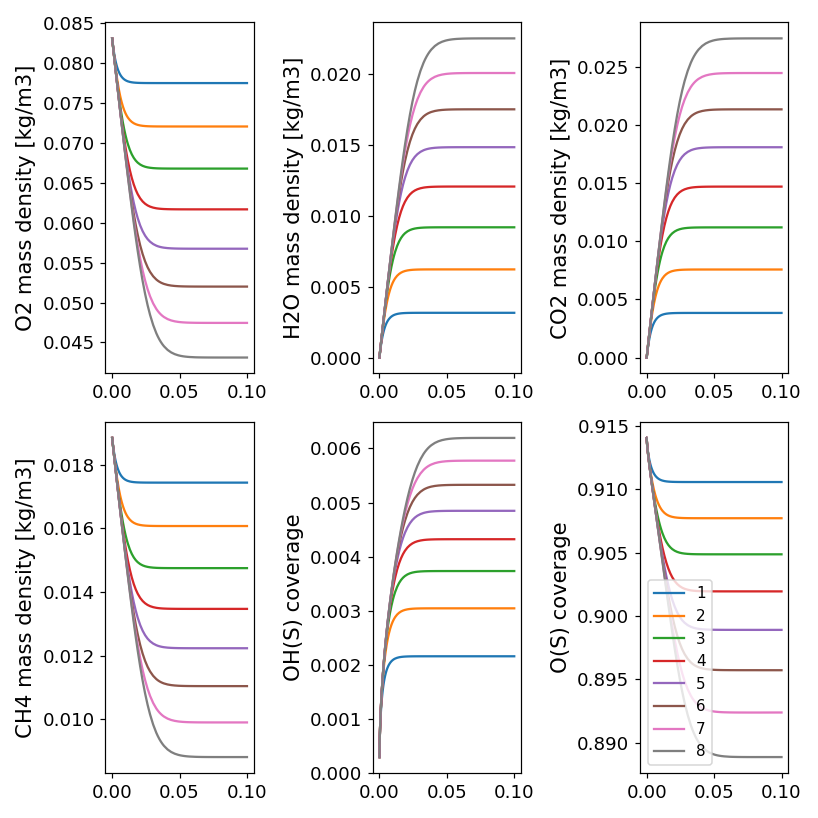

<IPython.core.display.Javascript object>


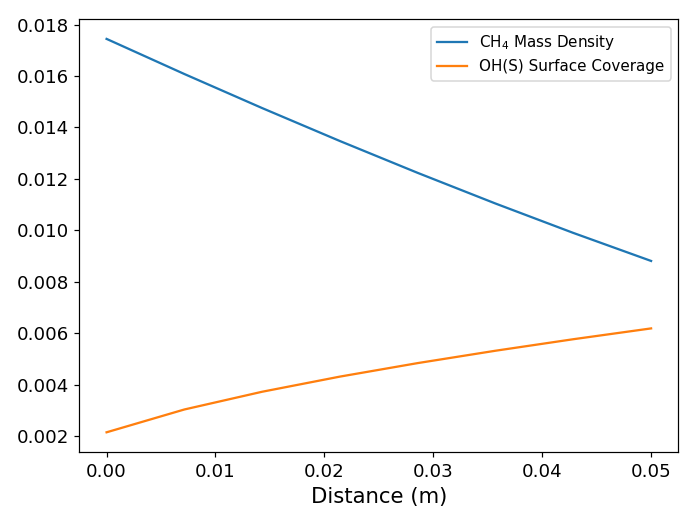

In [419]:
species = ['O2','H2O','CO2','CH4']

#fig = plt.figure()
fig, axs = plt.subplots(3,2,figsize=(7.5,7.5))
fig.subplots_adjust(hspace=0.05, wspace=0.05)
for j, sp in enumerate(species):
    i = gas.species_index(sp)
    plt.subplot(2,3,j+1)
    plt.xticks([0.,0.05,0.1,0.15,0.2])
    plt.ylabel(sp+' mass density [kg/m3]')
    for k in range(params.nz):
        plt.plot(sol.t.T,sol.y[i+k*params.n_vars])
        
surf_species = ['OH(S)','O(S)']
n_gas = len(species)
for j, sp in enumerate(surf_species):
    i = surf.species_index(sp)
    plt.subplot(2,3,n_gas+j+1)
    plt.xticks([0.,0.05,0.1])
    plt.ylabel(sp+' coverage')
    for k in range(params.nz):
        plt.plot(sol.t.T,sol.y[gas.n_species+i+k*params.n_vars])
    
nodes = []
for i in range(params.nz):
    nodes.append(str(i+1))
plt.legend(nodes)


fig2 = plt.figure()

rho_ch4 = []
theta_oh = []
i_ch4 = gas.species_index('CH4')
i_oh = surf.species_index('OH(S)')

for i in range(params.nz):
    rho_ch4.append(sol.y[i*params.n_vars+i_ch4,-1])
    theta_oh.append(sol.y[i*params.n_vars+gas.n_species+i_oh,-1])
    
z = np.linspace(0.,params.L_catcomb,params.nz)
plt.xlabel('Distance (m)')
    
plt.plot(z,rho_ch4,z,theta_oh)
plt.legend(['CH$_4$ Mass Density','OH(S) Surface Coverage'])
plt.show()